<a href="https://colab.research.google.com/github/MatthewSebastian15/cyclegan-day2night/blob/main/Deep_learning_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import pillow_heif
import seaborn as sns

# Load Dataset

In [ ]:
day = r"D:\KULIAH\SEMESTER 5\DEEP LEARNING\PROJECT\DATASET\DATA SEKUNDER\Day"
night = r"D:\KULIAH\SEMESTER 5\DEEP LEARNING\PROJECT\DATASET\DATA SEKUNDER\Night"

In [ ]:
day_Resized = r"D:\KULIAH\SEMESTER 5\DEEP LEARNING\PROJECT\DATASET\DATA SEKUNDER\Resized\Day"
night_Resized = r"D:\KULIAH\SEMESTER 5\DEEP LEARNING\PROJECT\DATASET\DATA SEKUNDER\Resized\Night"

os.makedirs(day_Resized, exist_ok=True)
os.makedirs(night_Resized, exist_ok=True)

# Data Preprocessing

## Show Image

In [ ]:
def show_image(input_dir, title=""):
    file_list = [f for f in os.listdir(input_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:20]
    plt.figure(figsize=(20, 5))
    for i, file_name in enumerate(file_list):
        img_path = os.path.join(input_dir, file_name)
        with Image.open(img_path) as img:
            plt.subplot(2, 10, i + 1)
            plt.imshow(img)
            plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

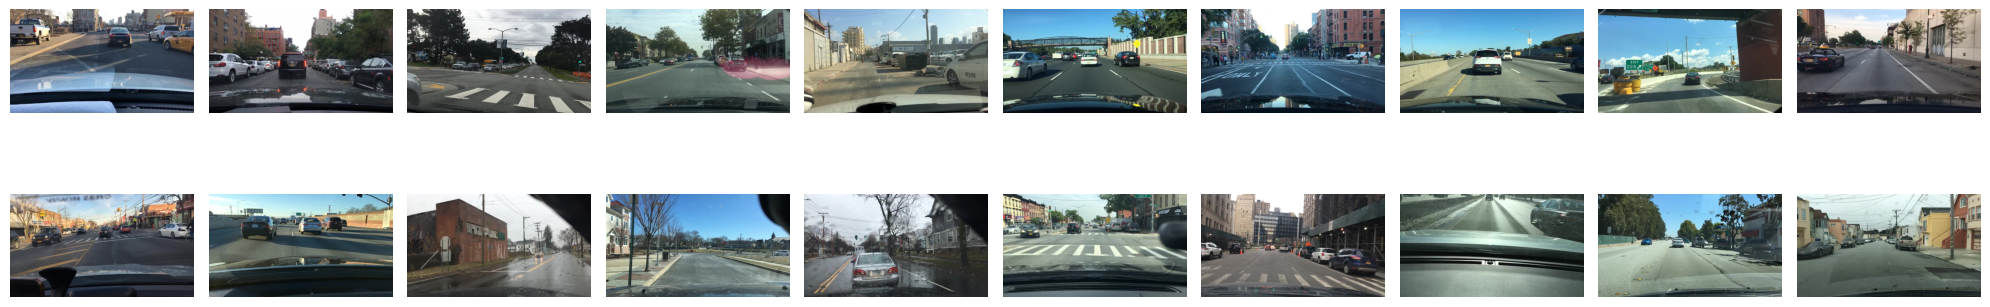

In [ ]:
show_image(day)

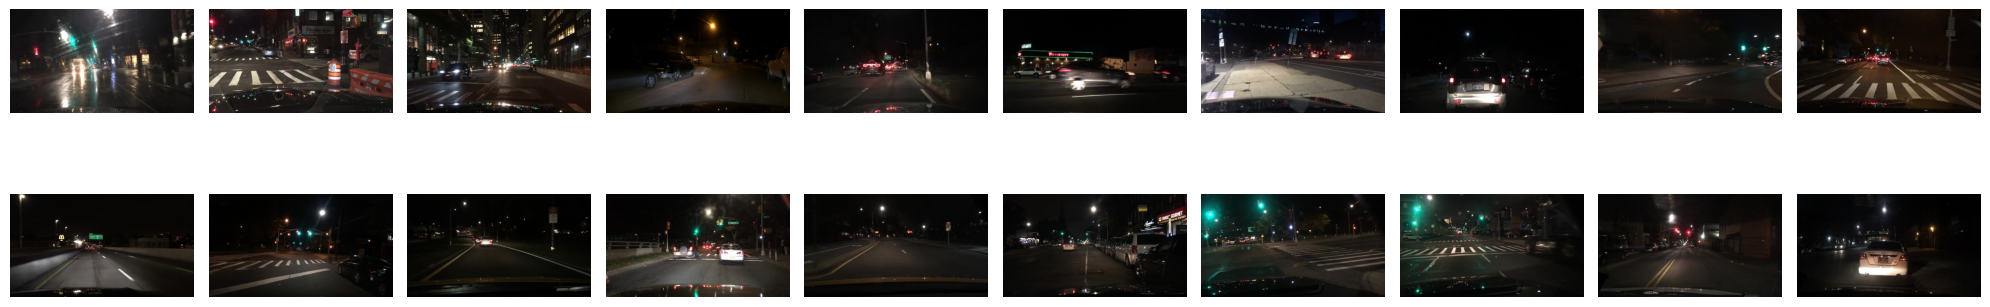

In [ ]:
show_image(night)

## Image Resize

In [ ]:
def resize_images(input_dir, output_dir, size=(256, 256)):
    for f in os.listdir(input_dir):
        if f.lower().endswith(('.jpg', '.jpeg', '.png')):
            path = os.path.join(input_dir, f)
            try:
                img = Image.open(path).convert("RGB")
                img = img.resize(size)
                img.save(os.path.join(output_dir, f))
            except Exception as e:
                print(f"Gagal resize {f}: {e}")

resize_images(day, day_Resized)
resize_images(night, night_Resized)

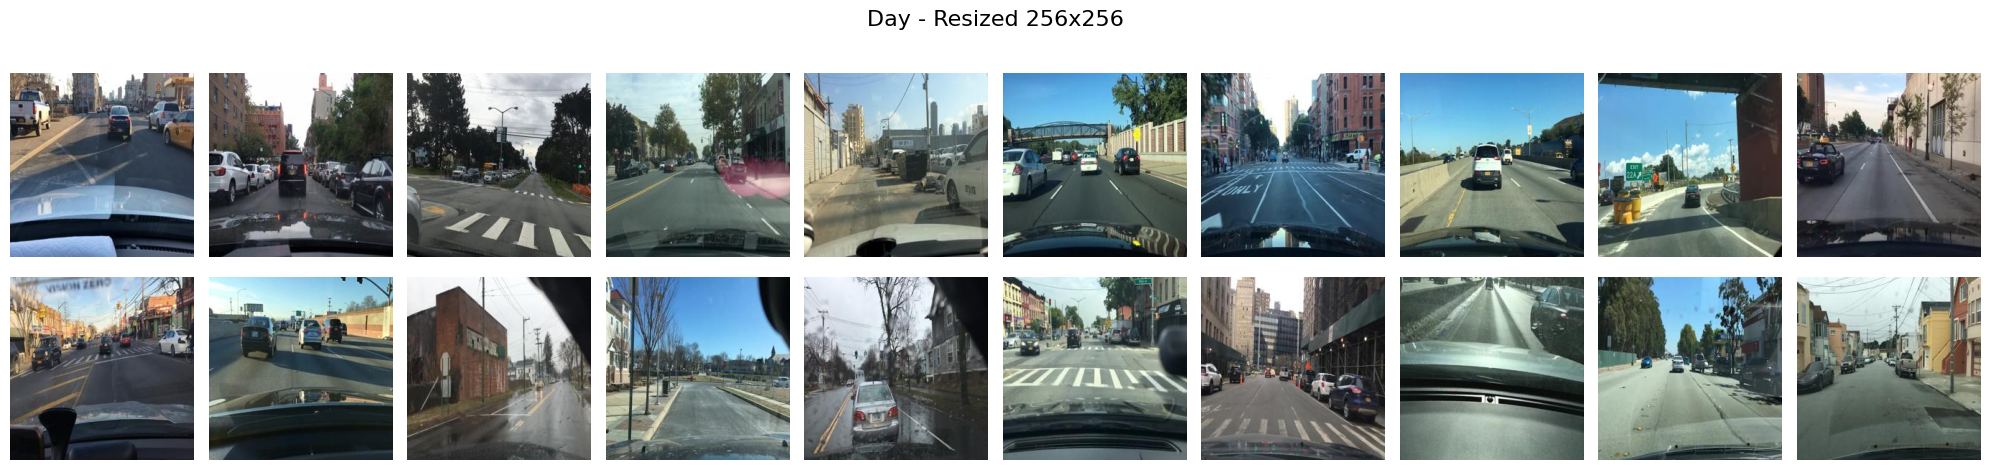

In [ ]:
show_image(day_Resized, title="Day - Resized 256x256")

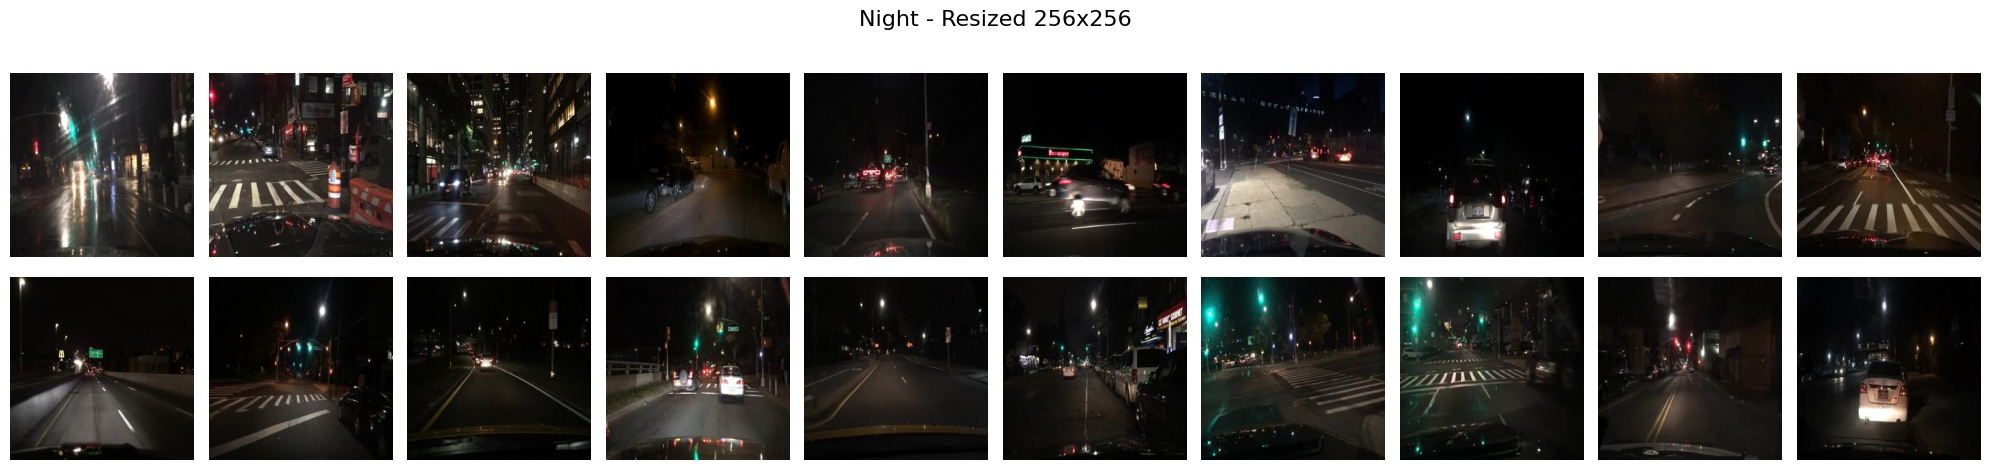

In [ ]:
show_image(night_Resized, title="Night - Resized 256x256")

## Image Normalization

In [ ]:
def preprocess_image(image_path, size=(256, 256)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, size)
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

# Exploratory Data Analysis (EDA)

## Number of Datasets

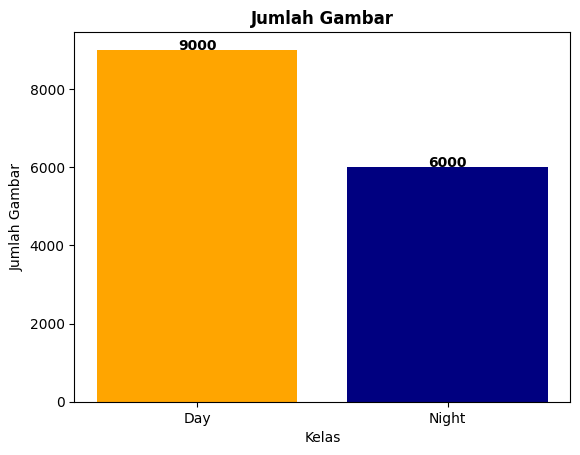

In [ ]:
num_day = len([f for f in os.listdir(day_Resized) if f.lower().endswith(('jpg', 'jpeg', 'png'))])
num_night = len([f for f in os.listdir(night_Resized) if f.lower().endswith(('jpg', 'jpeg', 'png'))])

labels = ["Day", "Night"]
values = [num_day, num_night]
colors = ["orange", "navy"]

plt.bar(labels, values, color=colors)

for i, v in enumerate(values):
    plt.text(i, v + 2, str(v), ha='center', fontweight='bold', fontsize=10, color='black')

plt.title("Jumlah Gambar", fontsize=12, fontweight='bold')
plt.ylabel("Jumlah Gambar")
plt.xlabel("Kelas")
plt.show()

## RGB distribution

In [ ]:
def visualize_RGB(image_path, title):
    img = np.array(Image.open(image_path).convert('RGB'))
    img = (img / 255.0)

    colors = ['red', 'green', 'blue']
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")

    for i, color in enumerate(colors):
        plt.subplot(1, 4, i + 2)
        plt.hist((img[:, :, i] * 255).flatten(), bins=50, color=color, alpha=0.7)
        plt.title(f"{color.capitalize()} Channel")

    plt.tight_layout()
    plt.show()

day_sample = os.path.join(day_Resized, os.listdir(day_Resized)[0])
night_sample = os.path.join(night_Resized, os.listdir(night_Resized)[0])

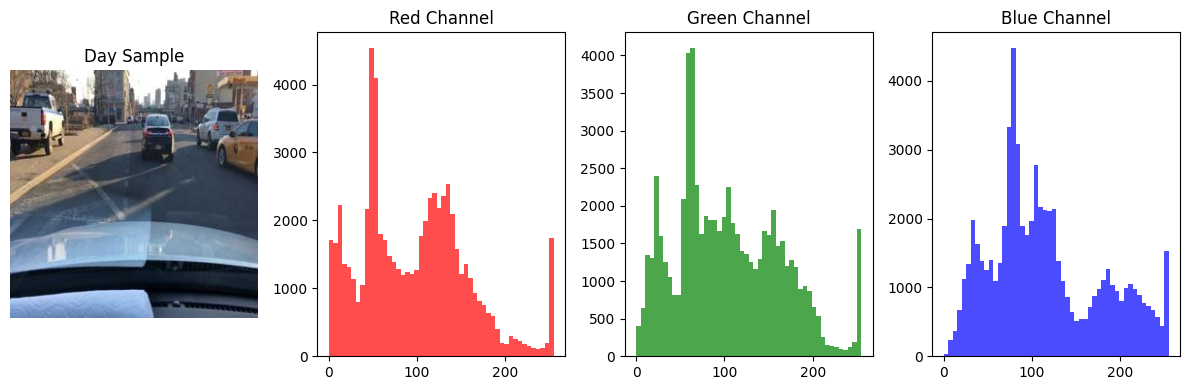

In [ ]:
visualize_RGB(day_sample, "Day Sample")

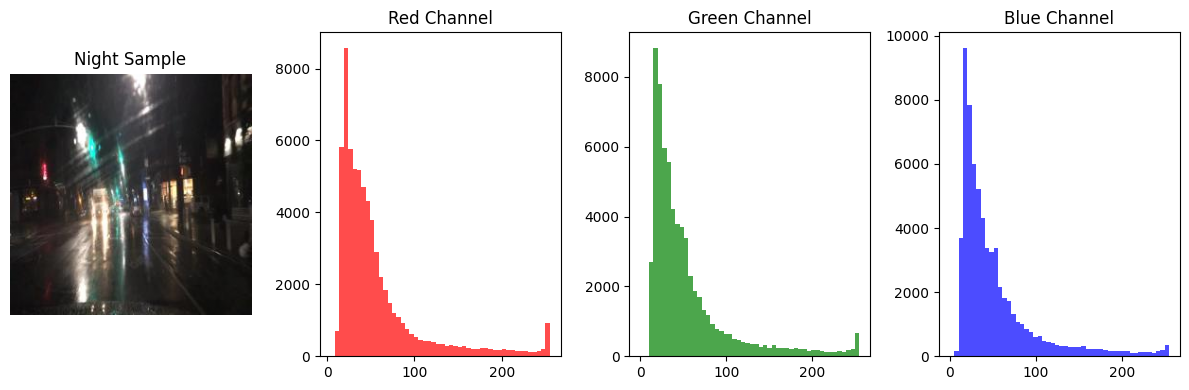

In [ ]:
visualize_RGB(night_sample, "Night Sample")

## Image Size

In [ ]:
def visualize_image_with_rgb(image_path):
    img = Image.open(image_path).convert("RGB").resize((256, 256))
    img_np = np.array(img)

    plt.figure(figsize=(10, 6))
    plt.subplot(2, 2, 1)
    plt.imshow(img_np)
    plt.title("Gambar 256x256x3")
    plt.xlabel("Lebar (px)")
    plt.ylabel("Tinggi (px)")
    plt.xticks(np.arange(0, 257, 64))
    plt.yticks(np.arange(0, 257, 64))
    plt.grid(True, linestyle="--", linewidth=0.5, color="white", alpha=0.7)
    plt.tight_layout()
    plt.show()

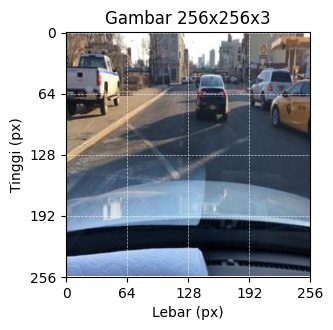

In [ ]:
visualize_image_with_rgb(day_sample)

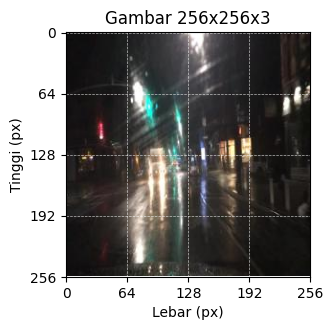

In [ ]:
visualize_image_with_rgb(night_sample)

## Brightness Distribution

In [ ]:
def plot_brightness_distribution(day_dir, night_dir):
    def avg_brightness(folder):
        values = []
        for f in os.listdir(folder):
            if f.lower().endswith(('jpg', 'jpeg', 'png')):
                img = Image.open(os.path.join(folder, f)).convert('L')
                values.append(np.mean(np.array(img)))
        return values

    day_vals = avg_brightness(day_dir)
    night_vals = avg_brightness(night_dir)

    plt.figure(figsize=(8, 5))
    sns.kdeplot(day_vals, color='gold', label='Day', fill=True)
    sns.kdeplot(night_vals, color='navy', label='Night', fill=True)
    plt.title("Distribusi Kecerahan Gambar", fontsize=13, fontweight="bold")
    plt.xlabel("Rata-rata Intensitas (0–255)")
    plt.ylabel("Kepadatan")
    plt.legend()
    plt.show()

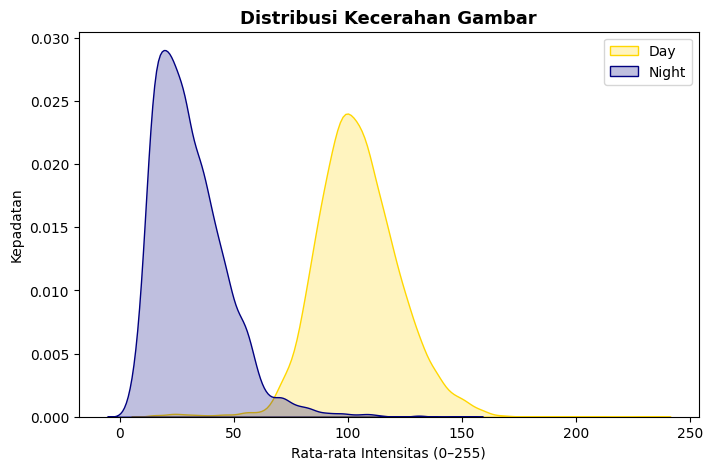

In [ ]:
plot_brightness_distribution(day_Resized, night_Resized)

## Dominant Color Comparison

In [ ]:
def plot_average_rgb_heatmap(day_dir, night_dir):
    def avg_rgb(folder):
        rgb_means = []
        for f in os.listdir(folder):
            if f.lower().endswith(('jpg', 'jpeg', 'png')):
                img = np.array(Image.open(os.path.join(folder, f)).convert('RGB'))
                rgb_means.append(img.mean(axis=(0, 1)))
        return np.array(rgb_means).mean(axis=0)

    day_avg = avg_rgb(day_dir)
    night_avg = avg_rgb(night_dir)

    data = np.array([day_avg, night_avg])
    plt.figure(figsize=(4, 2))
    sns.heatmap(data, annot=True, fmt=".1f", cmap="coolwarm", xticklabels=['R', 'G', 'B'], yticklabels=['Day', 'Night'])
    plt.title("Rata-rata Intensitas Warna per Domain")
    plt.show()

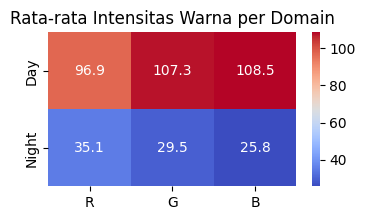

In [ ]:
plot_average_rgb_heatmap(day_Resized, night_Resized)